# Broadband directional coupler

In the rapidly evolving field of silicon integrated photonics, the directional coupler (DC) stands out as a crucial building block for a multitude of applications, such as optical signal processing, sensing, and communication systems. As a passive device, a DC allows for the precise manipulation and distribution of light between two parallel waveguides within close proximity, enabling highly efficient and compact coupling with minimal loss. This elegant, yet simple structure capitalizes on the waveguiding properties of silicon, leveraging the evanescent coupling between the propagating modes to achieve precise control over the flow of optical power, thereby playing a pivotal role in shaping the future of photonic integrated circuits.

Conventional compact DCs often face limitations in terms of narrow bandwidth, while broadband designs tend to require a significantly larger footprint. This document explores a design for compact, broadband DCs, as proposed in `Zeqin Lu, Han Yun, Yun Wang, Zhitian Chen, Fan Zhang, Nicolas A. F. Jaeger, and Lukas Chrostowski, "Broadband silicon photonic directional coupler using asymmetric-waveguide based phase control," Opt. Express 23, 3795-3808 (2015)`, [DOI: 10.1364/OE.23.003795](https://doi.org/10.1364/OE.23.003795). The key innovation in this design, as compared to traditional DCs, lies in its incorporation of an asymmetric-waveguide-based phase control section. To demonstrate a concrete example, we will design a 2x2 DC for the TE mode, with a 50%/50% (-3 dB) splitting ratio, operating within the 1500 nm to 1600 nm range. Different polarizations and splitting ratios can be achieved in a similar design process.

Initially, we employ the transfer matrix method (TMM) to model the DC in a semi-analytical manner. TMM necessitates the calculation of effective indices for various waveguide configurations, for which we utilize Tidy3D's [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/), as it offers a convenient means of performing mode analysis. TMM provides a computationally efficient and accurate preliminary estimation of the ideal design parameters, which are then further optimized using rigorous 3D FDTD simulations. 

<img src="img/broadband_DC_1.png" width="500" alt="Schematic of the DC">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [90 degree optical hybrid](https://www.flexcompute.com/tidy3d/examples/notebooks/90OpticalHybrid/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import waveguide

## Transfer Matrix Method (TMM) Analysis 

The broadband DC primarily consists of a symmetric coupler, an asymmetric phase control section, and another symmetric coupler. The three sections are connected via linear tapers. The inputs and outputs are from 90 degree circular bends. 

We can use TMM to analyze this system. Assuming the input and output fields on the waveguide are $E_1$, $E_2$, $E_3$, and $E_4$, each section of the DC can be represented by a matrix. That is, we can write down the following equation that connects the input and output fields:

$\begin{bmatrix}E_3\\E_4\end{bmatrix} = C \cdot P_t \cdot P \cdot P_t \cdot C \cdot \begin{bmatrix} E_1\\E_2 \end{bmatrix}$.

$C =\begin{bmatrix}t & -jk\\-jk & t\end{bmatrix} e^{-j\frac{\pi}{\lambda}(n_++n_-)L_1}$ represents the symmetric coupler. $t$ and $k$ are the transmission and coupling coefficients given by $t = cos(\frac{\pi\Delta n_{eff}}{\lambda}L_1) $ and $k = sin(\frac{\pi\Delta n_{eff}}{\lambda}L_1) $, where $\Delta n_{eff}=n_+-n_-$. $n_+$ and $n_-$ are the effective indices of the symmetric and anti-symmetric modes, which we will determine from mode analysis using the [waveguide plugin](../_autosummary/tidy3d.plugins.waveguide.RectangularDielectric.html). 

$P = \begin{bmatrix}e^{-j\frac{2\pi n_1}{\lambda}L_2} & 0\\0 & e^{-j\frac{2\pi n_2}{\lambda}L_2}\end{bmatrix}$ represents the asymmetric phase control section. Here $n_1$ and $n_2$ are the effective indices of the lowest order modes, which correspond to modes confined in the top waveguide and bottom waveguide, respectively. We will determine $n_1$ and $n_2$ from mode analysis too.

Lastly, $P_t = \begin{bmatrix}e^{-j\theta_{t1}} & 0\\0 & e^{-j\theta_{t2}}\end{bmatrix}$ approximately represents the linear tapers. $\theta_{t1}$ and $\theta_{t2}$ are the phase shifts in the top and bottom tapers, which we will determine numerically from quick FDTD simulations. 

In the [reference](https://opg.optica.org/oe/fulltext.cfm?uri=oe-23-3-3795), a small propagation loss of 2.7 dB/cm is also considered. Since this is a small factor, we choose to ignore it in the analysis without a significant loss of accuracy. 

After we perform the TMM calculation, we can determine the power splitting ratio by $\eta_{cross} = \frac{|E_4|^2}{|E_3|^2+|E_4|^2}$ and $\eta_{through} = \frac{|E_3|^2}{|E_3|^2+|E_4|^2}$, assuming the input field is $\begin{bmatrix}E_1\\0\end{bmatrix}$.


<img src="img/broadband_DC_2.png" width="700" alt="Top view of the DC">

We are interested in the wavelength range of 1500 nm to 1600 nm. 

In [2]:
lda0 = 1.55  # central wavelength
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range of interest
freq0 = td.C_0 / lda0  # central frequency
freqs = td.C_0 / ldas  # frequency range of interest
fwidth = 0.4 * (np.max(freqs) - np.min(freqs))  # frequency width of the source

The silicon layer is 220 nm. The waveguide width and gap size in the symmetric coupler are 500 nm and 200 nm, respectively.  

In [3]:
w_sc = 0.5  # width of waveguides in the symmetric coupler section
h_si = 0.22  # thickness of the silicon layer
gap_sc = 0.2  # gap size between the waveguides in the symmetric coupler section

To define the media, we directly use the dispersive medium model of silicon and oxide from Tidy3D's [material library](../material_library.html) for convenience. 

In [4]:
# define silicon and silicon dioxide media from material library
si = td.material_library["cSi"]["Li1993_293K"]
sio2 = td.material_library["SiO2"]["Horiba"]

Now we use the [waveguide plugin](../_autosummary/tidy3d.plugins.waveguide.RectangularDielectric.html) to perform the mode analysis on the symmetric coupler. Alternatively, one can use the [ModeSolver](../_autosummary/tidy3d.plugins.mode.ModeSolver.html) plugin to do the same analysis. The [waveguide plugin](../_autosummary/tidy3d.plugins.waveguide.RectangularDielectric.html) just provides a fast and convenient way of setting up the mode analysis for dielectric waveguides. 

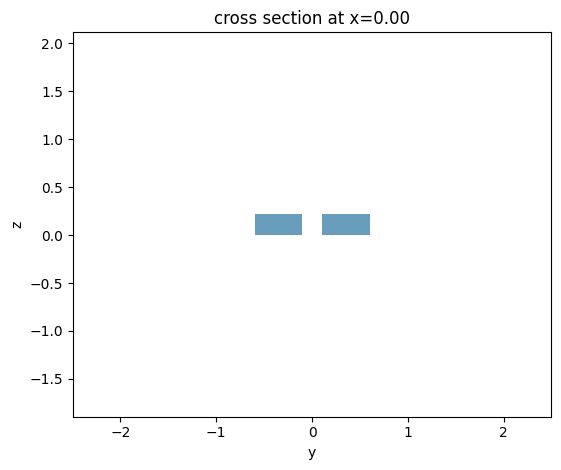

In [5]:
# define the symmetric coupler section
symmetric_coupler = waveguide.RectangularDielectric(
    wavelength=lda0,
    core_width=(w_sc, w_sc),
    core_thickness=h_si,
    core_medium=si,
    clad_medium=sio2,
    gap=gap_sc,
    grid_resolution=40,
    mode_spec=td.ModeSpec(num_modes=5, precision="double"),
)

# plot the cross section
symmetric_coupler.plot_structures(x=0)
plt.show()

The effective indices of different modes can be directly calculated. The corresponding mode profiles can be visualized. Here we focus on the two lowest order modes, which are the symmetric and anti-symmetric modes.

Effective indices: 2.4591626285321264, 2.438215232515221


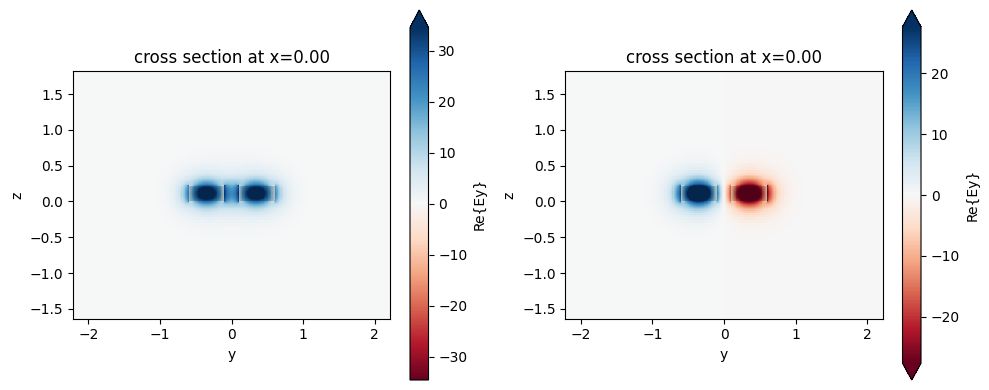

In [6]:
# compute the effective indices for the symmetric and anti-symmetric modes
n_p = symmetric_coupler.n_eff.values[0][0]
n_m = symmetric_coupler.n_eff.values[0][1]
del_n = n_p - n_m
print(f"Effective indices: {n_p}, {n_m}")

# plot the mode profiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

symmetric_coupler.plot_field("Ey", mode_index=0, ax=ax1)
symmetric_coupler.plot_field("Ey", mode_index=1, ax=ax2)

After obtaining $n_+$ and $n_-$, we will calculate $n_1$ and $n_2$ in a similar fashion for the phase control section, where the waveguide widths are 600 nm and 400 nm. The gap is 300 nm.

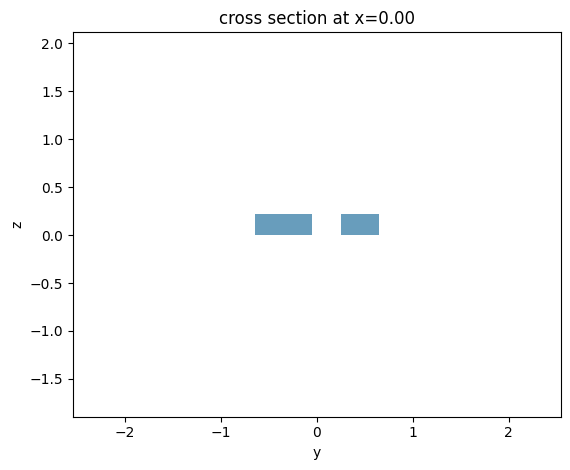

In [7]:
w_top = 0.6  # width of the top waveguide in the phase control section
w_bottom = 0.4  # width of the bottom waveguide in the phase control section
gap_pc = 0.3  # gap size in the phase control section

# define the phase control section
phase_control = waveguide.RectangularDielectric(
    wavelength=lda0,
    core_width=(w_top, w_bottom),
    core_thickness=h_si,
    core_medium=si,
    clad_medium=sio2,
    gap=gap_pc,
    grid_resolution=40,
    mode_spec=td.ModeSpec(num_modes=2, precision="double"),
)

# plot the cross section
phase_control.plot_structures(x=0)
plt.show()

Effective indices: 2.5682454486532205, 2.217684204006945


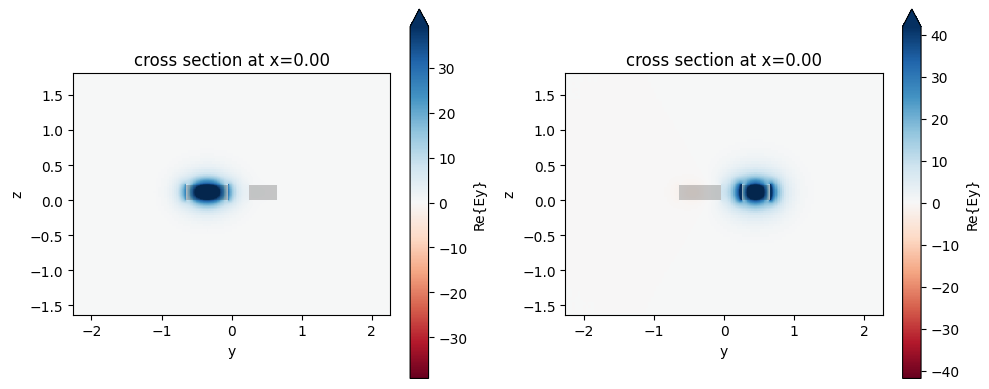

In [8]:
# compute the effective indices for the first two modes
n_1 = phase_control.n_eff.values[0][0]
n_2 = phase_control.n_eff.values[0][1]
print(f"Effective indices: {n_1}, {n_2}")

# plot the mode profiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

phase_control.plot_field("Ey", mode_index=0, ax=ax1)
phase_control.plot_field("Ey", mode_index=1, ax=ax2)

To perform the TMM analysis, we still need to obtain $\theta_{t1}$ and $\theta_{t2}$. This can be done by setting up FDTD simulations for the tapers. To get the phase shift, we place one [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) right before the taper and another [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) right after the taper. The phase difference calculated from the mode amplitudes is the phase shift we are looking for. Since the tapers are only 1 $\mu m$ in length, the FDTD simulations are very fast.

First, let's do the top taper that transitions from a 500 nm waveguide to a 600 nm waveguide.

In [9]:
L_t = 1  # length of the tapers
l = 10  # length of the straight waveguide

# define vertices
vertices = [(-l, 0), (L_t + l, 0), (L_t + l, w_top), (L_t, w_top), (0, w_sc), (-l, w_sc)]

# define the top taper structure
taper_top = td.Structure(
    geometry=td.PolySlab(
        vertices=vertices,
        axis=2,
        slab_bounds=(-h_si / 2, h_si / 2),
    ),
    medium=si,
)

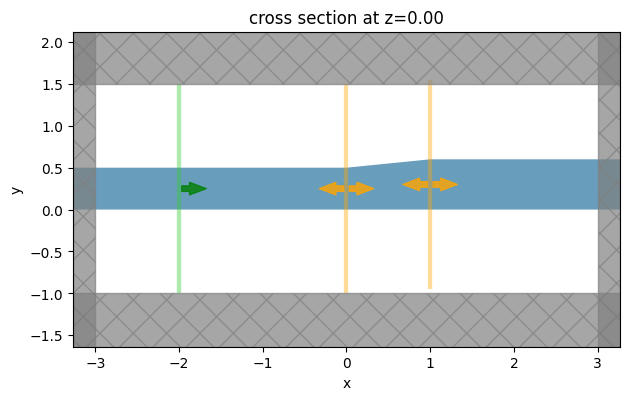

In [10]:
# simulation domain size
Lx = L_t + l / 2
Ly = 5 * w_sc
Lz = 9 * h_si

# define a mode source that injects te mode
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.47)
mode_source = td.ModeSource(
    center=(-l / 5, w_sc / 2, 0),
    size=(0, Ly, 4 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,
)

# define a mode monitor to measure the phase before the taper
mode_monitor_1 = td.ModeMonitor(
    center=(0, w_sc / 2, 0),
    size=(0, Ly, 4 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_1",
)

# define a mode monitor to measure the phase after the taper
mode_monitor_2 = td.ModeMonitor(
    center=(L_t, w_top / 2, 0),
    size=(0, Ly, 4 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_2",
)

run_time = 4e-13  # simulation run time

# define a simulation
sim = td.Simulation(
    center=(0, w_sc / 2, 0),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[taper_top],
    sources=[mode_source],
    monitors=[mode_monitor_1, mode_monitor_2],
    run_time=run_time,
    medium=sio2,
)

# plot simulation
sim.plot(z=0)
plt.show()

In [11]:
job = web.Job(simulation=sim, task_name="top_taper")
sim_data = job.run(path="data/simulation_data.hdf5")

[16:42:54] Created task 'top_taper' with task_id 'fdve-3f691c8b-caa1-4255-b66d-ee212dd385ffv1'.       ]8;id=559252;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=18738;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=130596;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=557282;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=679584;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3f691c8b-caa1-4255-b66d-ee212dd385ffv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=838701;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3f691c8b-caa1-4255-b66d-ee212dd385ffv1\taskId]8;;\]8;id=679584;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3f691c8b-caa1-4255-b66d-ee212dd385ffv1\=]8;;\]8;id=575726;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3f691c8b-caa1-4255-b66d-ee212dd385ffv1\fdve]8;;\]8;id=679584;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3f691c8b-caa1-4255-b66d-ee212dd385ffv1\-3f691c8b-caa1-4255-b66d-ee212dd385f]8;;\              
           ]8;id=679584;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3f691c8b-caa1-4255-b66d-ee212dd385ffv1\fv1']8;;\.                                                                                                   

Output()

[16:42:56] status = queued                                                                            ]8;id=514294;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=827205;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[16:42:59] status = preprocess                                                                        ]8;id=125885;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=149664;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[16:43:07] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=997865;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=294728;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=166663;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=789097;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=147931;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=309699;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[16:43:47] early shutoff detected, exiting.                                                           ]8;id=515320;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=572623;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=602808;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=609446;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[16:44:05] status = success                                                                           ]8;id=238837;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=432111;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[16:44:07] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=301437;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=667311;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Compute and plot $\theta_{t1}$. As expected, the phase shift is linear. Note that the phase is only significant mod 2$\pi$.

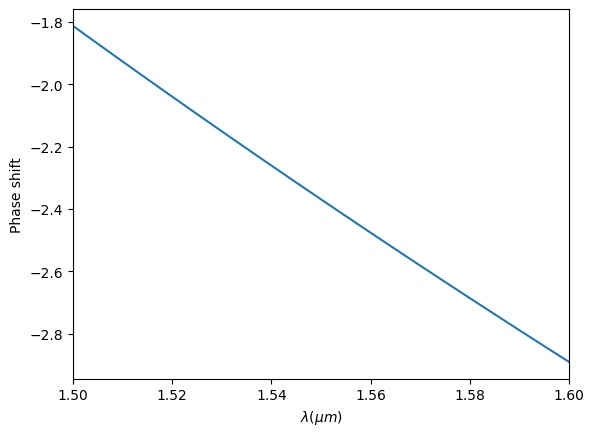

In [12]:
# phase at the first monitor
phase_1 = np.angle(sim_data["mode_1"].amps.sel(mode_index=0, direction="+"))

# phase at the second monitor
phase_2 = np.angle(sim_data["mode_2"].amps.sel(mode_index=0, direction="+"))

# phase shift at the top taper
theta_t1 = phase_2 - phase_1

plt.plot(ldas, np.unwrap(theta_t1))
plt.xlabel("$\lambda (\mu m)$")
plt.ylabel("Phase shift")
plt.xlim(1.5, 1.6)
plt.show()

Similarly, we simulate the taper that transitions from a 500 nm waveguide to a 300 nm waveguide.

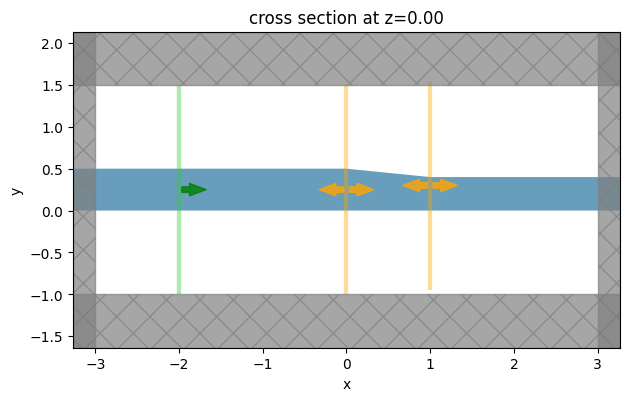

In [13]:
# define vertices
vertices = [(-l, 0), (L_t + l, 0), (L_t + l, w_bottom), (L_t, w_bottom), (0, w_sc), (-l, w_sc)]

# define the bottom taper structure
taper_bottom = td.Structure(
    geometry=td.PolySlab(
        vertices=vertices,
        axis=2,
        slab_bounds=(-h_si / 2, h_si / 2),
    ),
    medium=si,
)

# copy previous simulation and update the structure
sim = sim.copy(update={"structures": [taper_bottom]})
sim.plot(z=0)
plt.show()

Compute and plot $\theta_{t2}$.

[16:44:08] Created task 'bottom_taper' with task_id 'fdve-aa416702-720d-44b6-933b-bc15403bce64v1'.    ]8;id=315470;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=298952;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=798170;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=863643;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=146086;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa416702-720d-44b6-933b-bc15403bce64v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=569093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa416702-720d-44b6-933b-bc15403bce64v1\taskId]8;;\]8;id=146086;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa416702-720d-44b6-933b-bc15403bce64v1\=]8;;\]8;id=165391;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa416702-720d-44b6-933b-bc15403bce64v1\fdve]8;;\]8;id=146086;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa416702-720d-44b6-933b-bc15403bce64v1\-aa416702-720d-44b6-933b-bc15403bce6]8;;\              
           ]8;id=146086;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa416702-720d-44b6-933b-bc15403bce64v1\4v1']8;;\.                                                                                                   

Output()

[16:44:09] status = queued                                                                            ]8;id=142011;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=597485;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[16:44:12] status = preprocess                                                                        ]8;id=359372;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=892214;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[16:44:19] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=401117;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=438400;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=39205;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=982083;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

[16:44:20] running solver                                                                             ]8;id=940432;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=539520;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[16:45:00] early shutoff detected, exiting.                                                           ]8;id=656031;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=968909;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=857154;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=219372;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[16:45:10] status = success                                                                           ]8;id=689758;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=870801;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[16:45:12] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=206914;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=28865;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

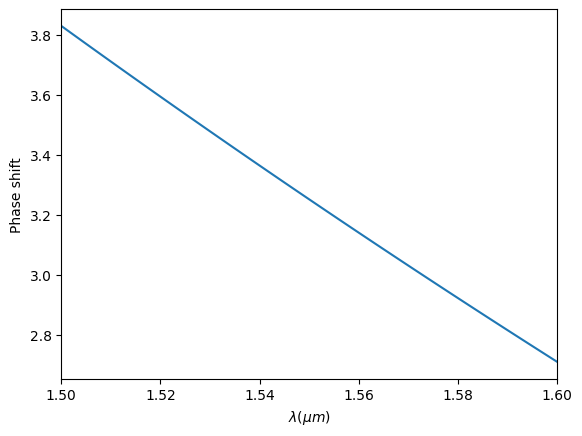

In [14]:
job = web.Job(simulation=sim, task_name="bottom_taper")
sim_data = job.run(path="data/simulation_data.hdf5")

# calculate phase shift
phase_1 = np.angle(sim_data["mode_1"].amps.sel(mode_index=0, direction="+"))
phase_2 = np.angle(sim_data["mode_2"].amps.sel(mode_index=0, direction="+"))
theta_t2 = phase_2 - phase_1

plt.plot(ldas, np.unwrap(theta_t2))
plt.xlabel("$\lambda (\mu m)$")
plt.ylabel("Phase shift")
plt.xlim(1.5, 1.6)
plt.show()

Now that we have calculated $n_+$, $n_-$, $n_1$, $n_2$, $\theta_{t1}$, and $\theta_{t2}$, we are ready to assemble the matrices and calculate $\eta_{cross}$. First, we focus on the wavelength of 1550 nm and explore $\eta_{cross}$ as a function of $L_1$ and $L_2$. 

In [15]:
# input field vector
E_in = np.array([[0], [1]])

N_L1 = 100  # number of L_1 points
N_L2 = 50  # number of L_2 points
L_1_array = np.linspace(4, 20, N_L1)
L_2_array = np.linspace(1, 6, N_L2)

eta_cross_1550 = np.zeros((N_L1, N_L2))

# compute the taper matrix
P_t = np.array([[np.exp(-1j * theta_t1[50]), 0], [0, np.exp(-1j * theta_t2[50])]]) * np.exp(-0.5)

for i, L_1 in enumerate(L_1_array):
    for j, L_2 in enumerate(L_2_array):

        # compute the transmission coefficient
        t = np.cos(np.pi * del_n * L_1 / lda0)
        # compute the coupling coefficient
        k = np.sin(np.pi * del_n * L_1 / lda0)
        # compute the symmetric coupler matrix
        C = np.exp(-1j * np.pi * (n_p + n_m) * L_1 / lda0) * np.array([[t, -1j * k], [-1j * k, t]])
        # compute the phase control section matrix
        P = np.array(
            [
                [np.exp(-1j * 2 * np.pi * n_1 * L_2 / lda0), 0],
                [0, np.exp(-1j * 2 * np.pi * n_2 * L_2 / lda0)],
            ]
        )
        # compute the output field vector by tmm
        E_out = np.dot(C, np.dot(P_t, np.dot(P, np.dot(P_t, np.dot(C, E_in)))))

        # total transmission
        T = np.abs(E_out[0]) ** 2 + np.abs(E_out[1]) ** 2
        # power transmitted to the cross port
        eta_cross_1550[i, j] = np.abs(E_out[0]) ** 2 / T

Plot $\eta_{cross}$ as a function of $L_1$ and $L_2$. Since we are looking for a specific power splitting ratio, we add contours to the plot. For a desirable splitting ratio, one only needs to pick design parameters on the specific contour. 

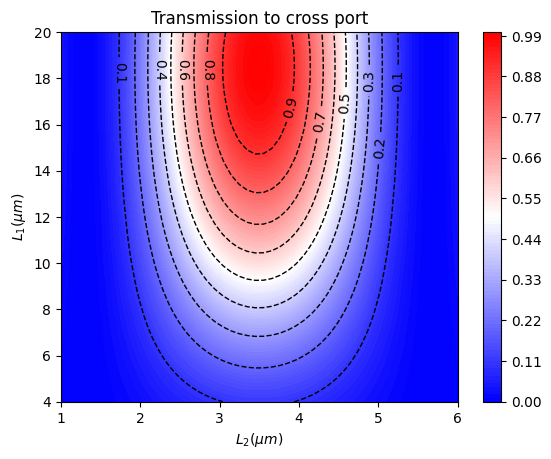

In [16]:
# plot the power transmitted to the cross port as a function of L_1 and L_2
cp = plt.contour(
    L_2_array,
    L_1_array,
    eta_cross_1550,
    levels=10,
    colors="black",
    linestyles="dashed",
    linewidths=1,
)
plt.clabel(cp, inline=1, fontsize=10)
cp = plt.contourf(L_2_array, L_1_array, eta_cross_1550, levels=100, vmin=0, vmax=1, cmap="bwr")
plt.xlabel("$L_2 (\mu m)$")
plt.ylabel("$L_1 (\mu m)$")
plt.title("Transmission to cross port")
plt.colorbar()
plt.show()

In this case, we aim for a 50%/50% splitting ratio. Since we want the DC to work in a wide wavelength range, we also need to calculate $\eta_{cross}$ at other wavelengths to make sure the same splitting ratio is maintained. Here we skip explicitly showing this step to avoid making the notebook excessively long. 

From this analysis, the optimal $L_1$ and $L_2$ are found to be 12.8 $\mu m$ and 4.4 $\mu m$. Now we fix $L_1$ and $L_2$ and calculate $\eta_{cross}$ as a function of wavelength.

In [17]:
L_1 = 12.8  # optimal L_1 from the tmm analysis
L_2 = 4.4  # optimal L_2 from the tmm analysis

# compute power transmitted to the cross port as a function of wavelength
eta_cross_ldas = np.zeros(len(ldas))
for i, lda in enumerate(ldas):
    t = np.cos(np.pi * del_n * L_1 / lda)
    k = np.sin(np.pi * del_n * L_1 / lda)
    C = np.exp(-1j * np.pi * (n_p + n_m) * L_1 / lda) * np.array([[t, -1j * k], [-1j * k, t]])

    P = np.array(
        [
            [np.exp(-1j * 2 * np.pi * n_1 * L_2 / lda), 0],
            [0, np.exp(-1j * 2 * np.pi * n_2 * L_2 / lda)],
        ]
    )

    E_out = np.dot(C, np.dot(P_t, np.dot(P, np.dot(P_t, np.dot(C, E_in)))))

    T = np.abs(E_out[0]) ** 2 + np.abs(E_out[1]) ** 2
    eta_cross_ldas[i] = np.abs(E_out[0]) ** 2 / T

Plot $\eta_{cross}$ as a function of wavelength. Here we can see if we define +- 1 dB as the bandwidth, the bandwidth is larger then 100 nm.

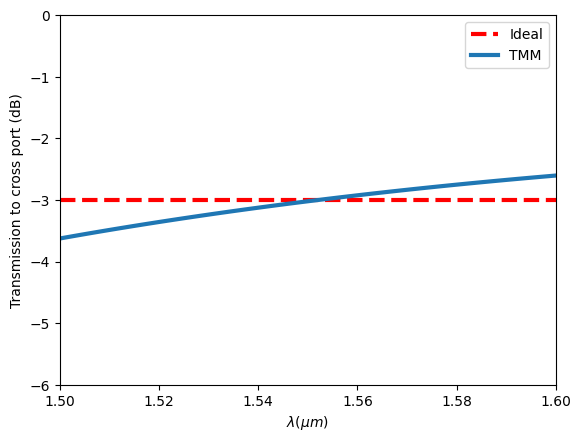

In [18]:
# plot the power transmitted to the cross port as a function of wavelength
plt.axhline(y=-3, color="r", linestyle="--", linewidth=3, label="Ideal")
plt.plot(ldas, 10 * np.log10(eta_cross_ldas), linewidth=3, label="TMM")
plt.legend()
plt.xlim(1.5, 1.6)
plt.ylim(-6, 0)
plt.xlabel("$\lambda (\mu m)$")
plt.ylabel("Transmission to cross port (dB)")
plt.show()

## 3D FDTD

The TMM analysis is only meant for an estimation of the optimal design parameters since TMM doesn't account for crucial details that can only be captured in a rigorous full wave simulation. Starting from the TMM analysis, we can further optimize $L_1$ and $L_2$ using 3D FDTD simulations. This can be done by performing a grid search (parameter sweeping), [adjoint optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/), or other gradient-free optimization around the initial values. Since parameter sweeping and adjoint optimization have been demonstrated in various examples such as the [MMI](https://www.flexcompute.com/tidy3d/examples/notebooks/MMI1x4/) and the [mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/), we won't do it again here but only report the final optimized design.

After some further optimization, we determine that the optimal $L_1$ and $L_2$ are 12.4 $\mu m$ and 4.7 $\mu m$, which is not far from the TMM estimation of 12.8$\mu m$ and 4.4 $\mu m$. Now we demonstrate the FDTD simulation on the optimized device. To define the DC structures, we use Tidy3D's built-in [PolySlab](../_autosummary/tidy3d.PolySlab.html). 

In [19]:
L_1 = 12.4  # optimal L_1 from the 3d fdtd analysis
L_2 = 4.7  # optimal L_2 from the 3d fdtd analysis

# define vertices of the top waveguide
vertices = [
    (L_2 / 2 + L_t + L_1, 0),
    (L_2 / 2 + L_t + L_1, w_sc),
    (L_2 / 2 + L_t, w_sc),
    (L_2 / 2, w_top),
    (-L_2 / 2, w_top),
    (-L_2 / 2 - L_t, w_sc),
    (-L_2 / 2 - L_t - L_1, w_sc),
    (-L_2 / 2 - L_t - L_1, 0),
]

# define the top waveguide
DC_top = td.Structure(
    geometry=td.PolySlab(
        vertices=vertices,
        axis=2,
        slab_bounds=(-h_si / 2, h_si / 2),
    ),
    medium=si,
)

# define vertices of the bottom waveguide
vertices = [
    (L_2 / 2 + L_t + L_1, -gap_sc - w_sc),
    (L_2 / 2 + L_t + L_1, -gap_sc),
    (L_2 / 2 + L_t, -gap_sc),
    (L_2 / 2, -gap_pc),
    (-L_2 / 2, -gap_pc),
    (-L_2 / 2 - L_t, -gap_sc),
    (-L_2 / 2 - L_t - L_1, -gap_sc),
    (-L_2 / 2 - L_t - L_1, -gap_sc - w_sc),
]

# define the bottom waveguide
DC_bottom = td.Structure(
    geometry=td.PolySlab(
        vertices=vertices,
        axis=2,
        slab_bounds=(-h_si / 2, h_si / 2),
    ),
    medium=si,
)

The input and output waveguides are connected to circular bends, which can be most conveniently defined using `gdstk`.

In [20]:
R = 5  # bend radius

cell = gdstk.Cell("bends")  # define a gds cell

# define the first input waveguide bend
bend_1 = gdstk.FlexPath((L_2 / 2 + L_t, w_sc / 2), w_sc, layer=1, datatype=0)
bend_1.horizontal(L_2 / 2 + L_t + L_1)
bend_1.arc(R, -np.pi / 2, 0)
bend_1.vertical(2 * l)
cell.add(bend_1)

# define the second input waveguide bend
bend_2 = bend_1.copy()
bend_2.mirror((0, 0), (0, 1))
cell.add(bend_2)

# define the third input waveguide bend
bend_3 = bend_1.copy()
bend_3.mirror((0, -gap_sc / 2), (1, -gap_sc / 2))
cell.add(bend_3)

# define the forth input waveguide bend
bend_4 = bend_2.copy()
bend_4.mirror((0, -gap_sc / 2), (1, -gap_sc / 2))
cell.add(bend_4)

# define the waveguide bend tidy3d geometries
bends_geo = td.PolySlab.from_gds(
    cell,
    gds_layer=1,
    axis=2,
    slab_bounds=(-h_si / 2, h_si / 2),
)

# define the waveguide bend tidy3d structures
bends = [td.Structure(geometry=bend_geo, medium=si) for bend_geo in bends_geo]

Define source, monitors, and simulation.

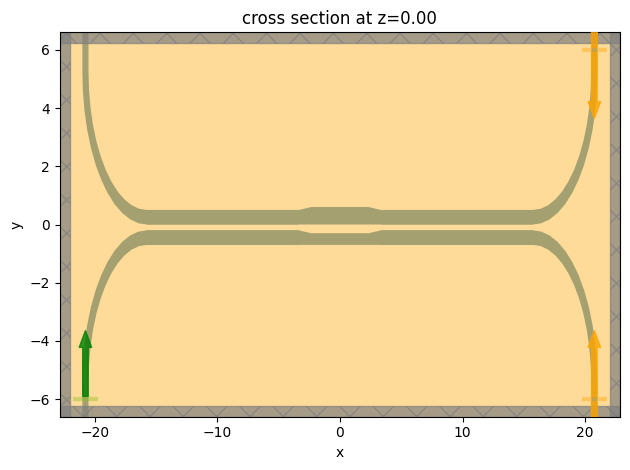

In [21]:
# define a mode source that injects te mode
mode_source = td.ModeSource(
    center=(-L_2 / 2 - L_t - L_1 - R, -R - l / 10, 0),
    size=(4 * w_sc, 0, 4 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,
)

# define a mode monitor to measure the transmission to cross port
mode_monitor_cross = td.ModeMonitor(
    center=(L_2 / 2 + L_t + L_1 + R, R + l / 10, 0),
    size=(4 * w_sc, 0, 4 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_cross",
)

# define a mode monitor to measure the transmission to through port
mode_monitor_through = td.ModeMonitor(
    center=(L_2 / 2 + L_t + L_1 + R, -R - l / 10, 0),
    size=(4 * w_sc, 0, 4 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_through",
)

# define a field monitor to visualize mode propagation
field_monitor = td.FieldMonitor(size=(td.inf, td.inf, 0), freqs=[freq0], name="field")

run_time = 2e-12  # simulation run time

# simulation domain size
Lx = 2 * L_1 + 2 * L_t + L_2 + 2 * R + l / 4
Ly = 2 * R + l / 4
Lz = 9 * h_si

# define a simulation
sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
    structures=bends + [DC_top, DC_bottom],
    sources=[mode_source],
    monitors=[mode_monitor_cross, mode_monitor_through, field_monitor],
    run_time=run_time,
    medium=sio2,
    symmetry=(0, 0, 1),
)

ax = sim.plot(z=0)
ax.set_aspect("auto")
plt.show()

Submit the simulation job to the server. Before running the simulation, we can get a cost estimation using `estimate_cost`. This prevents us from accidentally running large jobs that we set up by mistake. The estimated cost is the maximum cost corresponding to running all the time steps.

In [22]:
job = web.Job(simulation=sim, task_name="full_structure")
estimated_cost = web.estimate_cost(job.task_id)

print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')


[16:45:13] Created task 'full_structure' with task_id 'fdve-f5d18ac1-7e42-4b65-a8d7-e701ce376ea5v1'.  ]8;id=223863;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=723287;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=288619;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=510859;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=900668;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5d18ac1-7e42-4b65-a8d7-e701ce376ea5v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=598335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5d18ac1-7e42-4b65-a8d7-e701ce376ea5v1\taskId]8;;\]8;id=900668;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5d18ac1-7e42-4b65-a8d7-e701ce376ea5v1\=]8;;\]8;id=23741;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5d18ac1-7e42-4b65-a8d7-e701ce376ea5v1\fdve]8;;\]8;id=900668;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5d18ac1-7e42-4b65-a8d7-e701ce376ea5v1\-f5d18ac1-7e42-4b65-a8d7-e701ce376ea]8;;\              
           ]8;id=900668;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5d18ac1-7e42-4b65-a8d7-e701ce376ea5v1\5v1']8;;\.                                                                                                   

Output()

The estimated maximum cost is 0.286 Flex Credits.


The cost is reasonaly so we can run the simulation.

In [23]:
sim_data = job.run(path="data/simulation_data.hdf5")

[16:45:15] status = queued                                                                            ]8;id=797403;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=8421;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[16:45:18] status = preprocess                                                                        ]8;id=342545;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=341746;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[16:45:26] Maximum FlexCredit cost: 0.286. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=618219;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=773271;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=380867;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=490327;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=620216;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=576316;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[16:47:06] early shutoff detected, exiting.                                                           ]8;id=573489;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=508569;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=399733;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=547300;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[16:47:17] status = success                                                                           ]8;id=234038;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=627427;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[16:47:23] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=262935;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=513173;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

After the simulation is complete, we plot the splitting ratio and compare it to the ideal case. From the plot, we can see that the designed DC maintains a -3 dB splitting ratio very well across the wavelength range of interest. The bandwidth is larger than 100 nm. As a comparison, [traditional DCs](https://tidy3d.simulation.cloud/workbench?taskId=pa-45ba95c2-3ced-4331-8ea3-01c49041f516) have a much smaller working bandwidth.

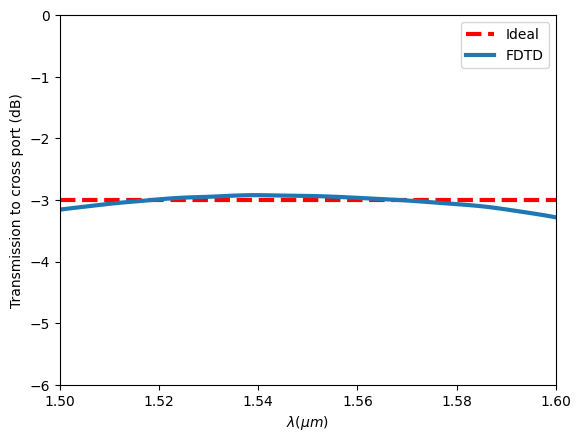

In [24]:
# calculate transmission to cross port
amp_cross = sim_data["mode_cross"].amps.sel(mode_index=0, direction="+")
T_cross = np.abs(amp_cross) ** 2

# calculate transmission to through port
amp_through = sim_data["mode_through"].amps.sel(mode_index=0, direction="-")
T_through = np.abs(amp_through) ** 2

T_total = T_cross + T_through  # total transmitted power

plt.axhline(y=-3, color="r", linestyle="--", linewidth=3, label="Ideal")
plt.plot(ldas, 10 * np.log10(T_cross / T_total), linewidth=3, label="FDTD")
plt.xlabel("$\lambda (\mu m)$")
plt.ylabel("Transmission to cross port (dB)")
plt.xlim(1.5, 1.6)
plt.ylim(-6, 0)
plt.legend()
plt.show()

Finally, visualize the power distribution at the central wavelength, which confirms the even splitting of power.

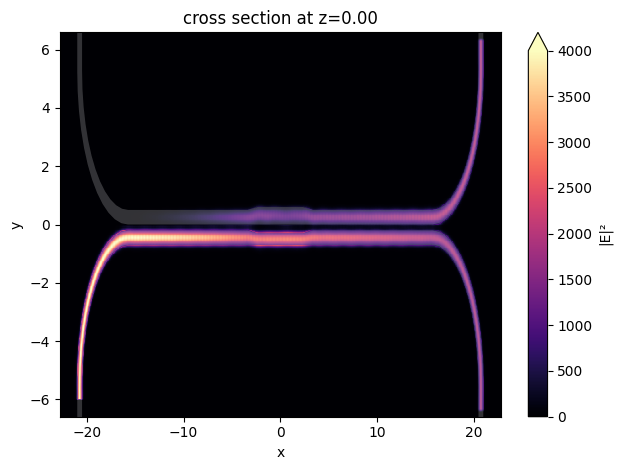

In [25]:
ax = sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", vmin=0, vmax=4000)
ax.set_aspect("auto")
plt.show()